# Explainability on Dataset with two classes

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random as rn
from os.path import join, getsize
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.style as style


from PIL import Image
from tqdm import tqdm

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

#InteractiveSession().close

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [2]:
BATCH_SIZE = 64
CHANNELS = 3
IMG_HEIGHT = 250
IMG_WIDTH = 250
IMG_SIZE=(IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE=IMG_SIZE + (3,)  # --> (224,224,3)


In [3]:
def reset_random_seed():
  """ Set the random seed.
   
  """
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]=str(2)

  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(2)

  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(2)

  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(2)
  

def get_dataset(path, img_size = IMG_SIZE, batch_size = BATCH_SIZE, shuffle = True):
    """ Get the dataset given the directory name.
    Args:
    - apth (str): a string representing the name of the directory from which the dataset is retrieved.
    
    Returns:
    - ds (PrefetchDataset): a Dataset containing the elements in the directory.
  """
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        seed = 2,
        image_size = img_size,
        batch_size = batch_size,
        shuffle = shuffle
    )



import math

def plot_images(list_images, list_labels, index_images):
  """ Plot the images with its label.
   
  """
  n = len(index_images)
  rows = math.ceil(n/4) # per eccesso
  print(rows)
  columns = 4 
  fig = plt.figure(figsize=(columns*3,rows*3))
  for i, index in enumerate(index_images):
    fig.add_subplot(rows, columns, i + 1)
    
    img = np.squeeze(list_images[index].numpy().astype("uint8"))
    
    title = "Image " + str(index) + ", class: "+str('Negative' if list_labels[i] == 0 else 'Positive')
    
    plt.title(title)
    plt.imshow(img)
    
  fig.tight_layout()
  plt.show()


def plot_images_from_ds(list_images, list_labels, index_images):
  """ Plot the images with its label directly from the dataset.
   
  """
  n = len(index_images)
  rows = math.ceil(n/4) # per eccesso
  print(rows)
  columns = 4 
  
  fig = plt.figure(figsize=(columns*5,rows*5))
  for i, image_batch in enumerate(list_images):
    
    for j, index in enumerate(index_images):
      if i == int(index/BATCH_SIZE):
        index_batch = index%BATCH_SIZE
        img = image_batch[0][index_batch]
        
        fig.add_subplot(rows, columns, j + 1)
        
        img = np.squeeze(img.numpy().astype("uint8"))

        if j < 2:
          title = "Image " + str(index) + ", class: "+str('Negative' if list_labels[j] == 0 else 'Positive')
        else:
          title = "Image " + str(index) + ", class: "+str('Negative(Pred: Positive)' if list_labels[j] == 0 else 'Positive(Pred: Negative)')
       
        plt.title(title)
        plt.imshow(img)
      
  fig.tight_layout()
  plt.show()

def extract_images_from_ds(list_images, list_labels, index_images):
  """ Extract the images  directly from the dataset.
   
  """
  img_extracted = []
  for i, image_batch in enumerate(list_images):
    
    for j, index in enumerate(index_images):
      if i == int(index/BATCH_SIZE):
        index_batch = index%BATCH_SIZE
        img = image_batch[0][index_batch]
        img_extracted.append(img)
        
      
  return img_extracted
  
  

In [4]:
general_path = './'
path_dataset = './binary_dataset_splitted_balanced/'
path_test = path_dataset + 'test/'
general_path_models = general_path+'/models/'

In [5]:
reset_random_seed()
test_ds_250 = get_dataset(path_test, img_size=(250,250), batch_size=64, shuffle=False)
test_ds_240 = get_dataset(path_test, img_size=(240,240), batch_size=64, shuffle=False)
test_ds_240_2 = get_dataset(path_test, img_size=(90,90), batch_size=1, shuffle=False)

Found 10532 files belonging to 2 classes.
Found 10532 files belonging to 2 classes.
Found 10532 files belonging to 2 classes.


In [6]:
test_set_images =  tf.concat([image_batch for image_batch, _ in test_ds_240_2], axis = 0)

In [7]:
# load the list of images always correct classified and always miscassified (ATTENTION: This lists are saved in Error Analysis Notebook)
with open('image_correct_classified_final_2.npy', 'rb') as f:
    images_correct_classified = np.load(f)
    
with open('image_always_misclassified_final_2.npy', 'rb') as f:
    images_always_misclassified = np.load(f)

Divide in classes the correct classified and misclassified images. Select, in a random way, the images to take as reference for the analysis

In [8]:
positive_correct_classified = []
negative_correct_classified = []
for images in images_correct_classified:
    if images[1] == 0:
        negative_correct_classified.append(images.tolist())
    else:
        positive_correct_classified.append(images.tolist())

positive_misclassified = []
negative_misclassified = []

for images in images_always_misclassified:
    if images[1] == 0:
        negative_misclassified.append(images.tolist())
    else:
        positive_misclassified.append(images.tolist())



1


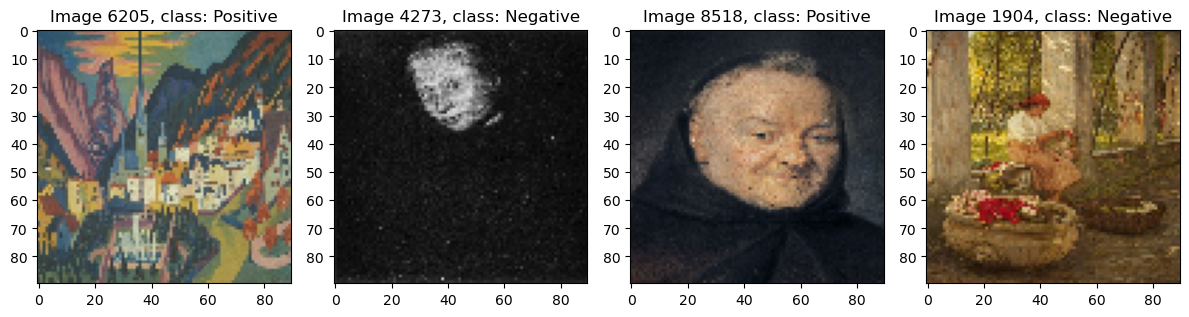

In [14]:
# select in a random way the images to take as reference
index_correct_image_positive = rn.randint(0, len(positive_correct_classified)-1) 
index_correct_image_negative = rn.randint(0, len(negative_correct_classified)-1)

index_misclassified_image_positive = rn.randint(0, len(positive_misclassified)-1)
index_misclassified_image_negative = rn.randint(0, len(negative_misclassified)-1)

plot_images(test_set_images,
            [positive_correct_classified[index_correct_image_positive][1], # pass list of correct and misclassified images
             negative_correct_classified[index_correct_image_negative][1],
             positive_misclassified[index_misclassified_image_positive][1],
             negative_misclassified[index_misclassified_image_negative][1]],
             [positive_correct_classified[index_correct_image_positive][0], # pass list of labels associated to the images selected
             negative_correct_classified[index_correct_image_negative][0],
             positive_misclassified[index_misclassified_image_positive][0],
             negative_misclassified[index_misclassified_image_negative][0]])

1


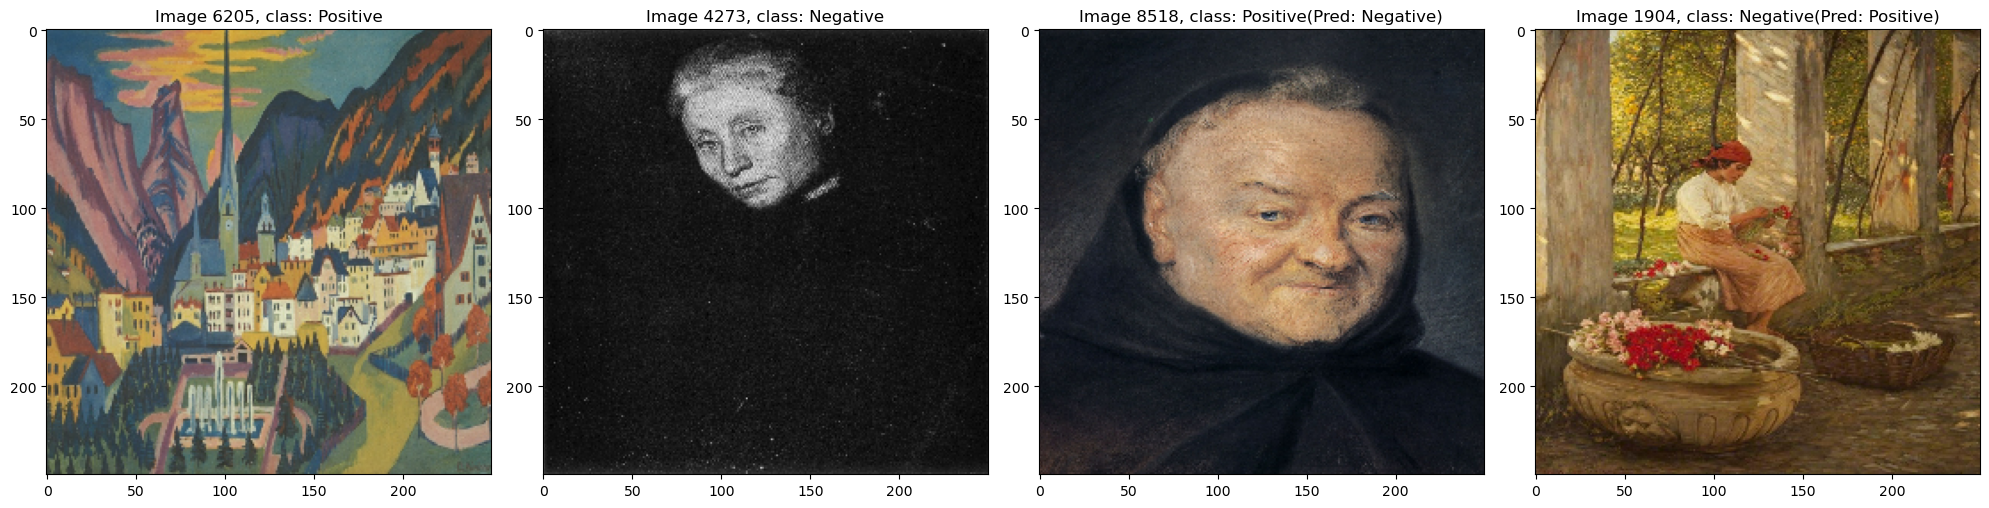

In [15]:
# plot images selected
plot_images_from_ds(test_ds_250,
            [positive_correct_classified[index_correct_image_positive][1],
             negative_correct_classified[index_correct_image_negative][1],
             positive_misclassified[index_misclassified_image_positive][1],
             negative_misclassified[index_misclassified_image_negative][1]],
             [positive_correct_classified[index_correct_image_positive][0],
             negative_correct_classified[index_correct_image_negative][0],
             positive_misclassified[index_misclassified_image_positive][0],
             negative_misclassified[index_misclassified_image_negative][0]])

In [16]:
# extract the images from the dataset
images_extracted = extract_images_from_ds(test_ds_250,
            [positive_correct_classified[index_correct_image_positive][1],
             negative_correct_classified[index_correct_image_negative][1],
             positive_misclassified[index_misclassified_image_positive][1],
             negative_misclassified[index_misclassified_image_negative][1]],
             [positive_correct_classified[index_correct_image_positive][0],
             negative_correct_classified[index_correct_image_negative][0],
             positive_misclassified[index_misclassified_image_positive][0],
             negative_misclassified[index_misclassified_image_negative][0]])

images_extracted_240 = extract_images_from_ds(test_ds_240,
            [positive_correct_classified[index_correct_image_positive][1],
             negative_correct_classified[index_correct_image_negative][1],
             positive_misclassified[index_misclassified_image_positive][1],
             negative_misclassified[index_misclassified_image_negative][1]],
             [positive_correct_classified[index_correct_image_positive][0],
             negative_correct_classified[index_correct_image_negative][0],
             positive_misclassified[index_misclassified_image_positive][0],
             negative_misclassified[index_misclassified_image_negative][0]])

In [17]:
from_scratch_0 = general_path_models+'/extra_binary_models_sc/ex0_scratch_dpplus2_32_128_epoch_30_adam_1e-4.h5' 
from_scratch_1 = general_path_models+'/binary_models_sc/ex10_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5'

path_pretrained_vgg16 = general_path_models+'/binary_models_sc/pretrained_vgg16_FINE_tuning_exp1_block5_conv1_512_dp_epoch_40_adam_1e-4.h5'
 
path_pretrained_resnet50 = general_path_models+'/extra_binary_models_sc/pretrained_RESNET_no_tuning_512_dp_epoch_40_adam_1e-4.h5' 
path_pretrained_mobilnet = general_path_models+'/extra_binary_models_sc/pretrained_MOBILENETV2_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5'
path_pretrained_xception = general_path_models+'/binary_models_sc/pretrained_XCEPTION_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5'

Utilities Function for Explainability

In [18]:
import matplotlib.cm as cm

def pooling_importance_function(grads, last_conv_layer_output):
    """Return heatmap that highlights the parts of the image more significant for the model"""
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately --> returns a vector of 2048 elements
  
    weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]

    for i in range(pooled_grads.shape[-1]):
        weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


def compute_grad(classifier_model, last_conv_layer_model, image):
        """Compute the gradient in order to buid the heatmap"""
        with tf.GradientTape() as tape:
                last_conv_layer_output = last_conv_layer_model(image) # output feature maps of the last conv layer.
                tape.watch(last_conv_layer_output)
                preds = classifier_model(last_conv_layer_output)  
                top_pred_index = tf.argmax(preds[0])  #  index
                top_class_channel = preds[:, top_pred_index] #  prediction value
                
        grads = tape.gradient(top_class_channel, last_conv_layer_output)

        heatmap = pooling_importance_function(grads, last_conv_layer_output)

        return heatmap

def superimposed_images_generation(heatmaps, images_extracted = images_extracted):
    """Overlap the heatmaps with the images"""
    superimposed_images = []
    for i, heatmap in enumerate(heatmaps):

        img = images_extracted[i]
        heatmap = np.uint8(255 * heatmap)

        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * 0.9 + img
        superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
        superimposed_images.append(superimposed_img)

    return superimposed_images

## Explainability Analysis

For each model loaded, we will analyze which are the features maps more activated to determine the final class

### From Scratch from_scratch_0

In [19]:
model_from_scratch_0 = tf.keras.models.load_model(from_scratch_0)

model_from_scratch_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                       

In [20]:
images_array = []
pred_images = []
for img in images_extracted:
    images_array.append(np.expand_dims(img, axis=0))
    pred_images.append(model_from_scratch_0.predict(np.expand_dims(img, axis=0)))

pred_images

[array([[0.37381002, 0.62618995]], dtype=float32),
 array([[0.88218415, 0.11781581]], dtype=float32),
 array([[0.35294405, 0.6470559 ]], dtype=float32),
 array([[0.63095325, 0.36904678]], dtype=float32)]

In [21]:
last_conv_layer_name = "conv2d_8" # last conv layer
last_conv_layer = model_from_scratch_0.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model_from_scratch_0.inputs, last_conv_layer.output)

In [22]:
classifier_layer_names = [
    "global_average_pooling2d_2",
    "dense_4",
    "dense_5"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_from_scratch_0.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

classifier_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 128)]       0         
                                                                 
 global_average_pooling2d_2   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 16,770
Trainable params: 16,770
Non-trainable params: 0
_________________________________________________________________


Heatmap

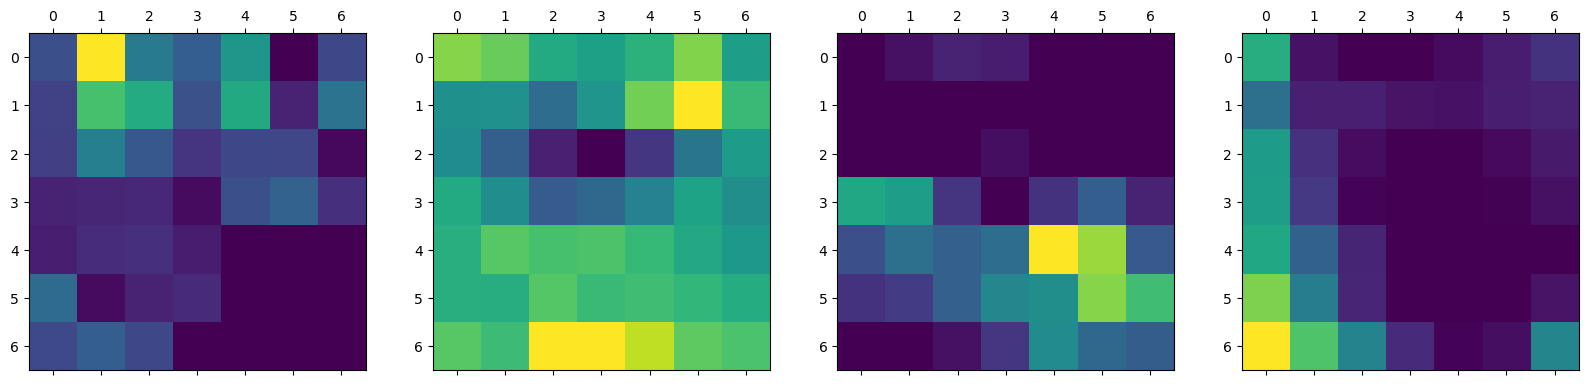

In [23]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)


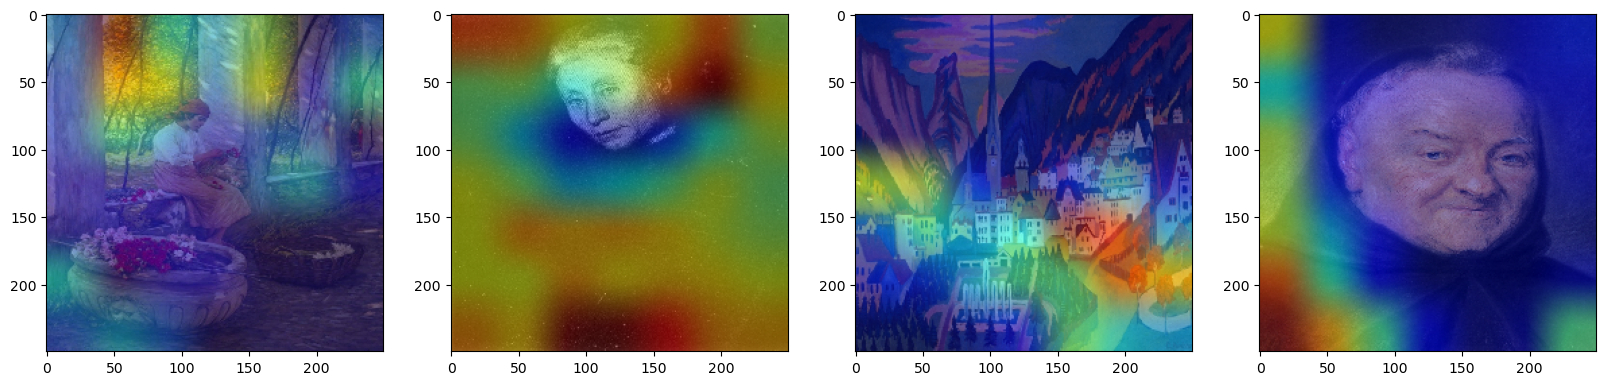

In [24]:
superimposed_images = superimposed_images_generation(heatmaps)

plt.figure(figsize= (20,20)) 
for i, superimposed_img in enumerate(superimposed_images):#plot images overlapping the heatmap
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### From Scratch from_scratch_1

In [25]:
model_from_scratch_1 = tf.keras.models.load_model(from_scratch_1)

model_from_scratch_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                       

In [26]:
images_array = []
pred_images = []
for img in images_extracted_240:
    images_array.append(np.expand_dims(img, axis=0))
    pred_images.append(model_from_scratch_1.predict(np.expand_dims(img, axis=0)))

pred_images

[array([[0.32111236, 0.67888767]], dtype=float32),
 array([[0.76514685, 0.23485316]], dtype=float32),
 array([[0.26165086, 0.73834914]], dtype=float32),
 array([[0.59339374, 0.40660623]], dtype=float32)]

In [27]:
last_conv_layer_name = "conv2d_13" # last conv layer
last_conv_layer = model_from_scratch_1.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model_from_scratch_1.inputs, last_conv_layer.output)

In [28]:
classifier_layer_names = [
    "flatten",
    "dense_2",
    "dense_3"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_from_scratch_1.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

classifier_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 12, 512)]     0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               37749248  
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 37,750,274
Trainable params: 37,750,274
Non-trainable params: 0
_________________________________________________________________


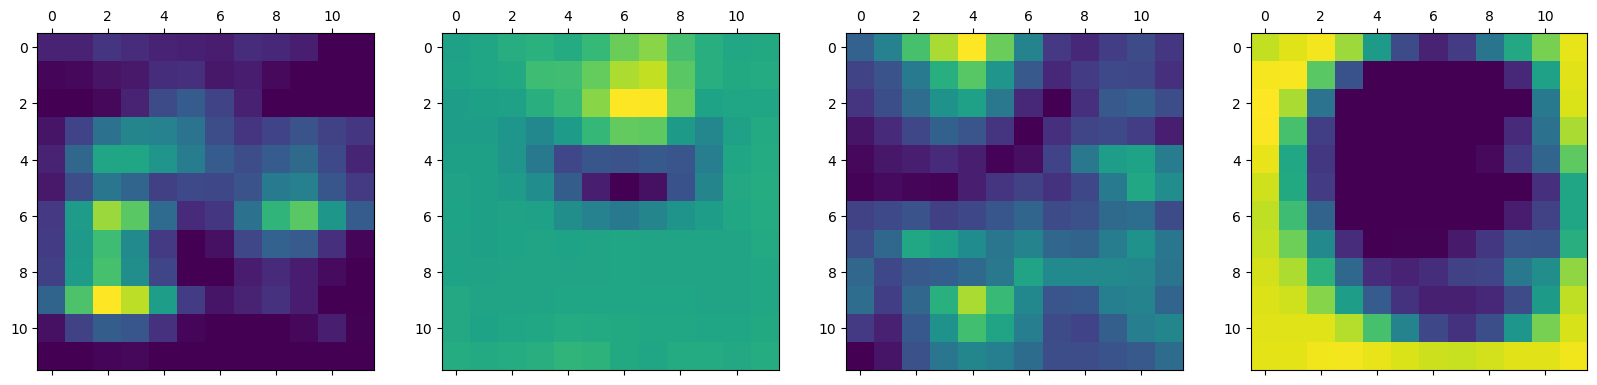

In [29]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

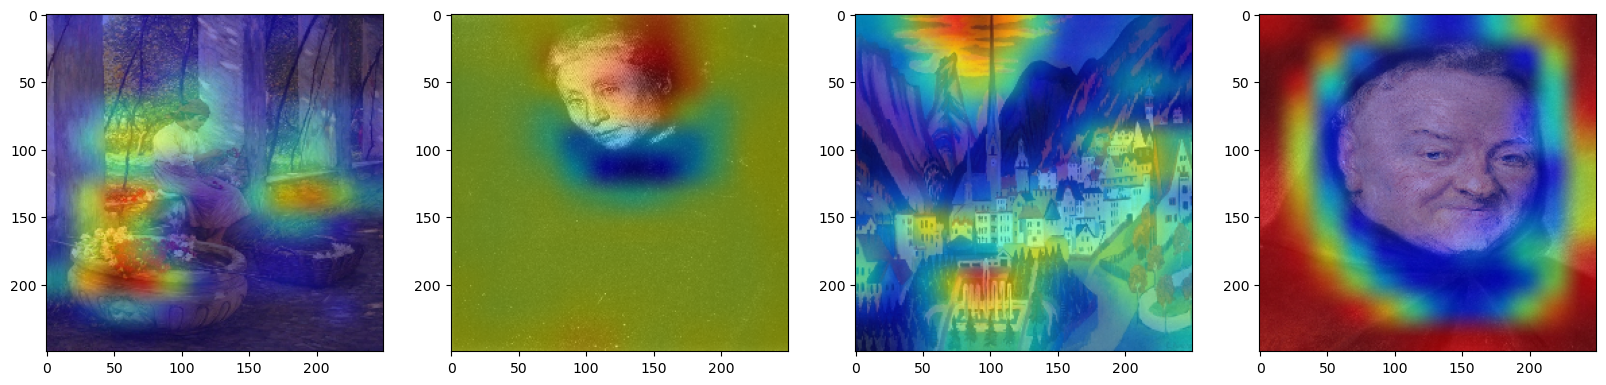

In [30]:
superimposed_images = superimposed_images_generation(heatmaps)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### VGG16

In [31]:
model_vgg16 = tf.keras.models.load_model(path_pretrained_vgg16)

model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 240, 240, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 240, 240, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [32]:
vgg16 = model_vgg16.get_layer('vgg16')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [34]:
images_array = []
pred_images = []
for img in images_extracted_240:
    img_prec = tf.keras.applications.vgg16.preprocess_input(img)
    images_array.append(np.expand_dims(img_prec, axis=0))
    pred_images.append(model_vgg16.predict(np.expand_dims(img, axis=0)))

pred_images

[array([[0.30770558, 0.6922945 ]], dtype=float32),
 array([[0.80848694, 0.19151312]], dtype=float32),
 array([[0.36116162, 0.6388384 ]], dtype=float32),
 array([[0.573151, 0.426849]], dtype=float32)]

In [35]:
last_conv_layer_name = "block5_conv3" #last conv layer
last_conv_layer = vgg16.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(vgg16.inputs, last_conv_layer.output)
last_conv_layer_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [37]:

classifier_layer_names = [
    "global_average_pooling2d",
    "dense",
    "dense_1",
    "dense_2",
    "dense_3",
    "dense_4"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_vgg16.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

classifier_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 15, 512)]     0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                           

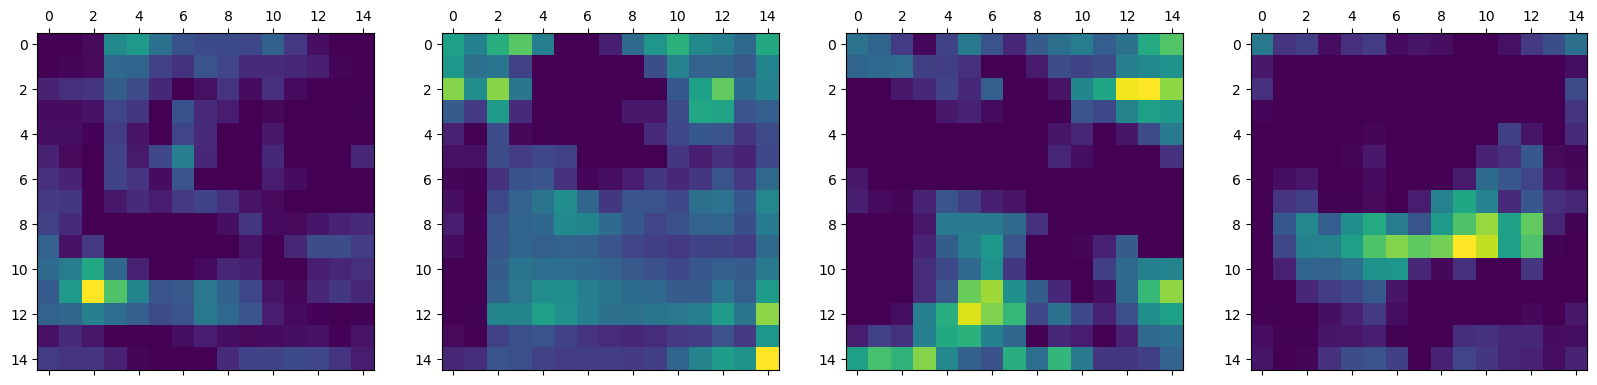

In [38]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

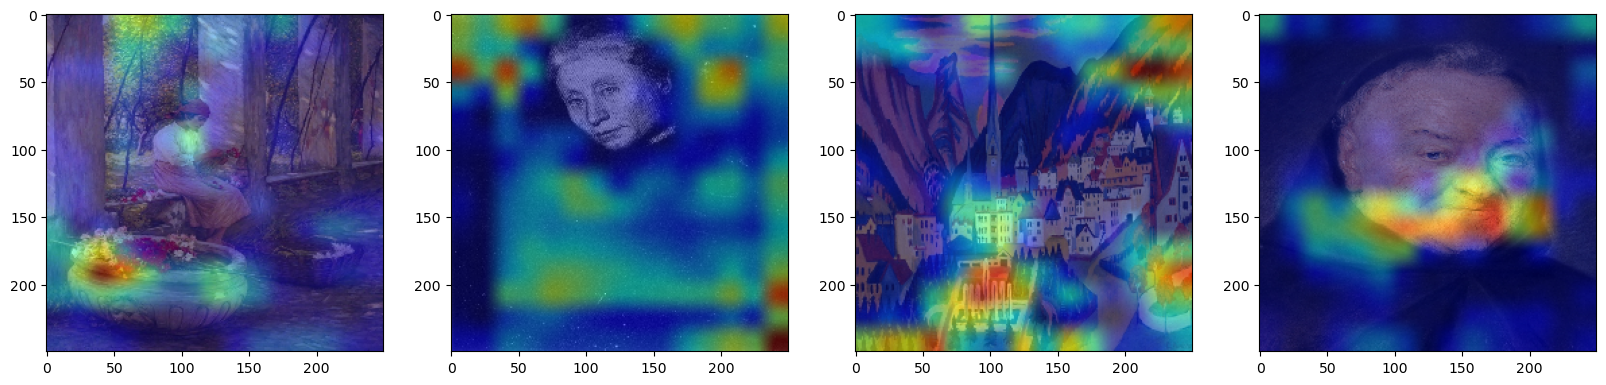

In [39]:
superimposed_images = superimposed_images_generation(heatmaps)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images): #plot images overlapping the heatmap
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### RESNET-50

In [43]:
model_resnet50 = tf.keras.models.load_model(path_pretrained_resnet50)

model_resnet50.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [44]:
resnet50 = model_resnet50.get_layer('resnet50')
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [45]:
images_array = []
pred_images = []
for img in images_extracted:
    img_prec = tf.keras.applications.resnet.preprocess_input(img)
    images_array.append(np.expand_dims(img_prec, axis=0))
    pred_images.append(model_resnet50.predict(np.expand_dims(img, axis=0)))

pred_images

[array([[0.23437296, 0.765627  ]], dtype=float32),
 array([[0.90193397, 0.09806604]], dtype=float32),
 array([[0.26112503, 0.738875  ]], dtype=float32),
 array([[0.67019725, 0.3298028 ]], dtype=float32)]

In [46]:
last_conv_layer_name = "conv5_block3_out" #last conv layer
last_conv_layer = resnet50.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(resnet50.inputs, last_conv_layer.output)
last_conv_layer_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [47]:
classifier_layer_names = [
    "global_average_pooling2d_4",
    "dense_9",
    "dense_10"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_resnet50.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

classifier_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8, 8, 2048)]      0         
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 dense_10 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 1,050,114
Trainable params: 1,050,114
Non-trainable params: 0
_________________________________________________________________


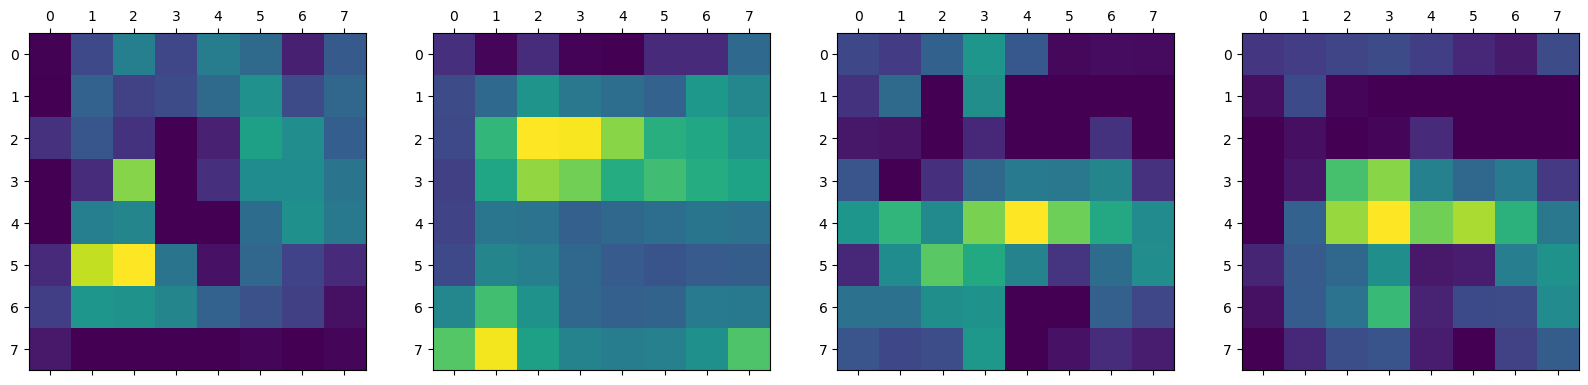

In [48]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)


plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

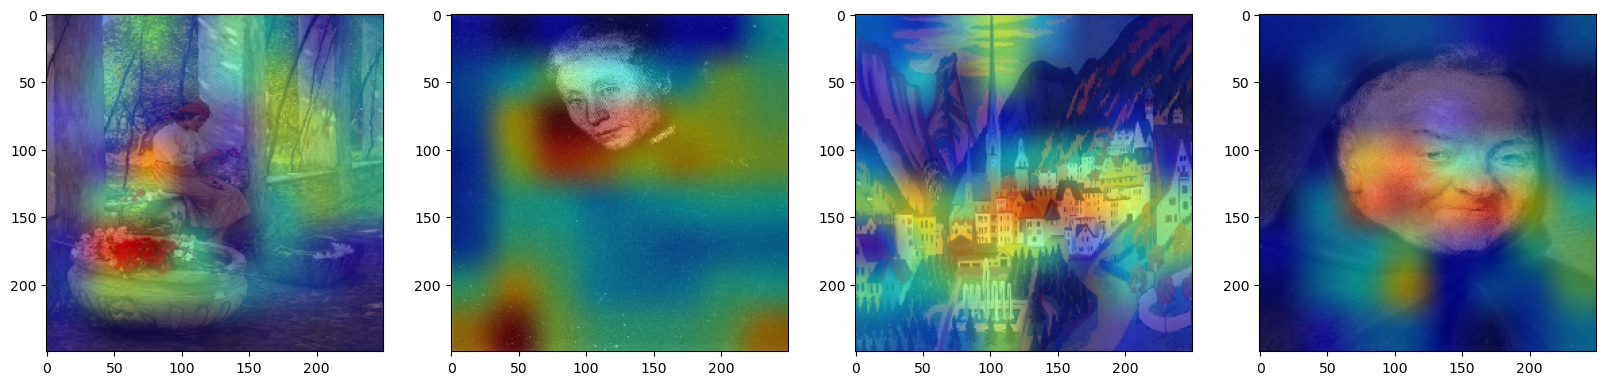

In [49]:
superimposed_images = superimposed_images_generation(heatmaps)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images): #plot images overlapping the heatmap
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### MOBILENET

In [53]:
model_mobilnet = tf.keras.models.load_model(path_pretrained_mobilnet)

model_mobilnet.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [54]:
mobilnet = model_mobilnet.get_layer('mobilenetv2_1.00_224')
mobilnet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 125, 125, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 125, 125, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [55]:
images_array = []
pred_images = []
for img in images_extracted:
    img_pre = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    images_array.append(np.expand_dims(img_pre, axis=0))
    pred_images.append(model_mobilnet.predict(np.expand_dims(img, axis=0)))

pred_images

[array([[0.15562594, 0.84437406]], dtype=float32),
 array([[0.91032314, 0.0896768 ]], dtype=float32),
 array([[0.40174657, 0.5982534 ]], dtype=float32),
 array([[0.7270061 , 0.27299398]], dtype=float32)]

In [56]:
last_conv_layer_name = "Conv_1" # last conv layer
last_conv_layer = mobilnet.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(mobilnet.inputs, last_conv_layer.output)


In [57]:
classifier_layer_names = [
    "global_average_pooling2d_5",
    "dense_11",
    "dense_12"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_mobilnet.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

classifier_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8, 8, 1280)]      0         
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 512)               655872    
                                                                 
 dense_12 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 656,898
Trainable params: 656,898
Non-trainable params: 0
_________________________________________________________________


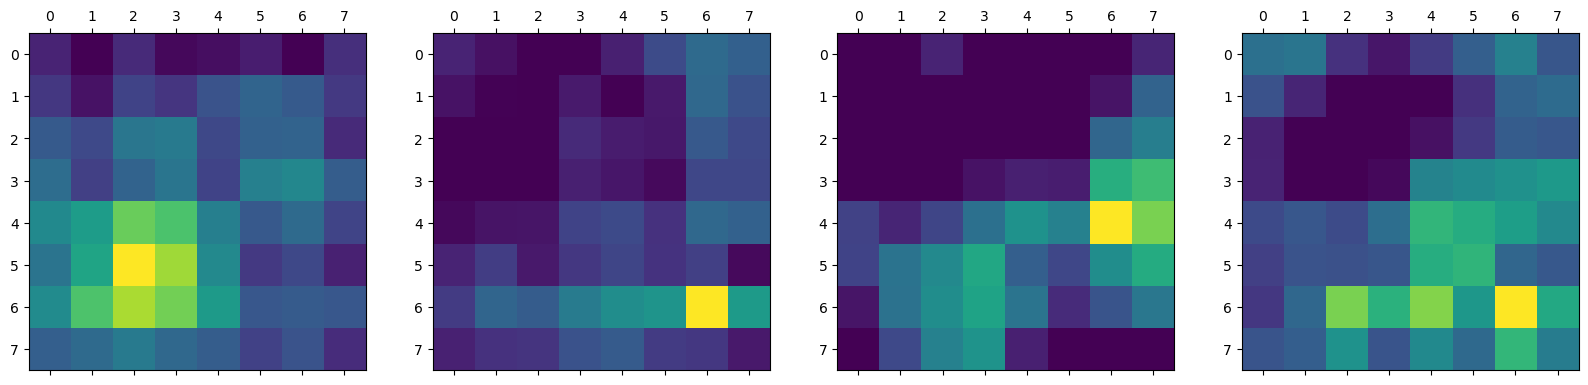

In [58]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

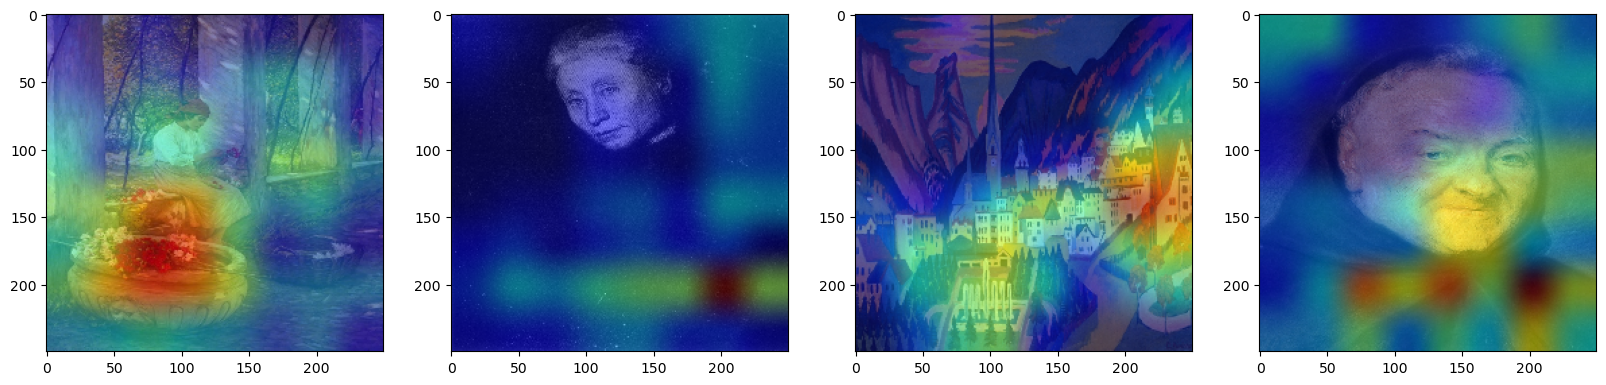

In [59]:
superimposed_images = superimposed_images_generation(heatmaps)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images): #plot images overlapping the heatmap
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### XCEPTION

In [60]:
model_xception = tf.keras.models.load_model(path_pretrained_xception)

model_xception.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [61]:
xception = model_xception.get_layer('xception')
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [62]:
images_array = []
pred_images = []
for img in images_extracted:
    img_pre = tf.keras.applications.xception.preprocess_input(img)
    images_array.append(np.expand_dims(img_pre, axis=0))
    pred_images.append(model_xception.predict(np.expand_dims(img, axis=0)))

pred_images

[array([[0.09764206, 0.90235794]], dtype=float32),
 array([[0.89770645, 0.10229359]], dtype=float32),
 array([[0.17444754, 0.82555246]], dtype=float32),
 array([[0.8750631 , 0.12493688]], dtype=float32)]

In [63]:
last_conv_layer_name = "block14_sepconv2_act" # last conv layer
last_conv_layer = xception.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(xception.inputs, last_conv_layer.output)

In [64]:
classifier_layer_names = [
    "global_average_pooling2d",
    "dense",
    "dense_1"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_xception.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

classifier_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8, 8, 2048)]      0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 1,050,114
Trainable params: 1,050,114
Non-trainable params: 0
_________________________________________________________________


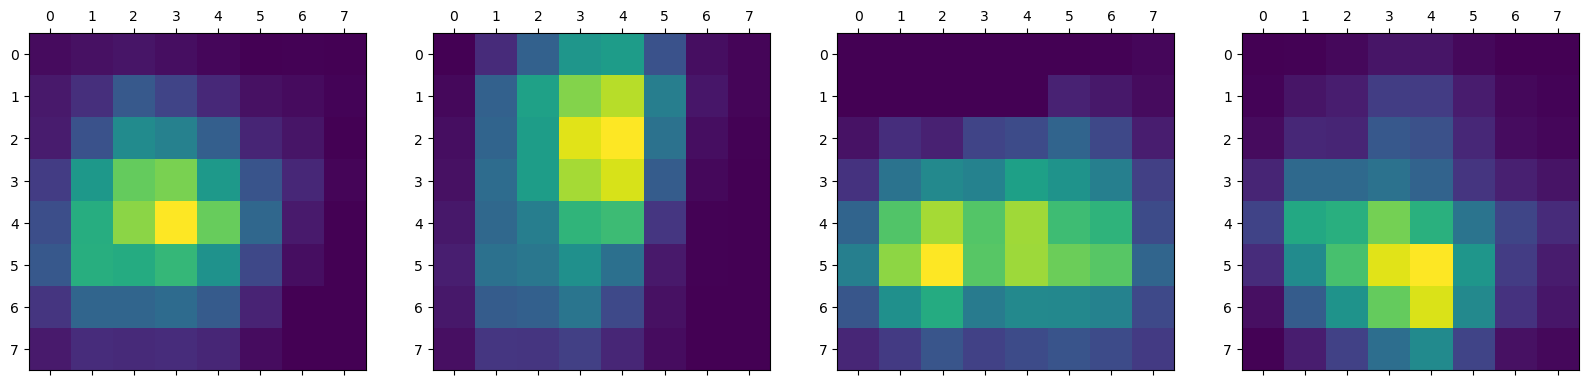

In [65]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

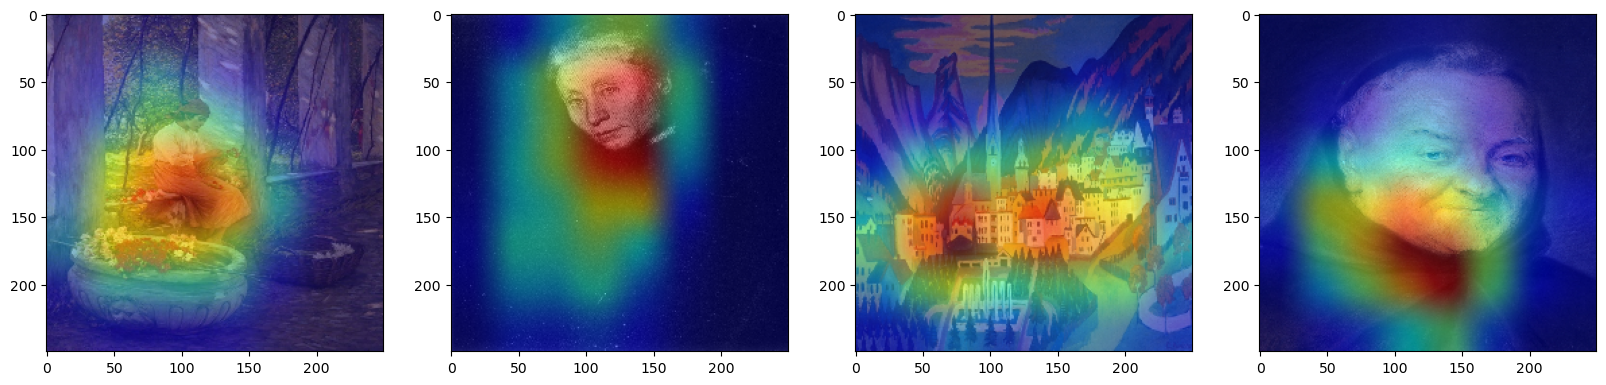

In [66]:
superimposed_images = superimposed_images_generation(heatmaps)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images): #plot images overlapping the heatmap
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)